In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
from numpy import random as rrr
from sklearn.model_selection import train_test_split
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
from time import time
from koopman_bandit import KoopmanBandit
import joblib

In [2]:
from scipy.signal import convolve2d

In [3]:
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
#device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [4]:
#define the domain of the dynamical system
x_min= -3
x_max= 3
y_min = -4
y_max= 4

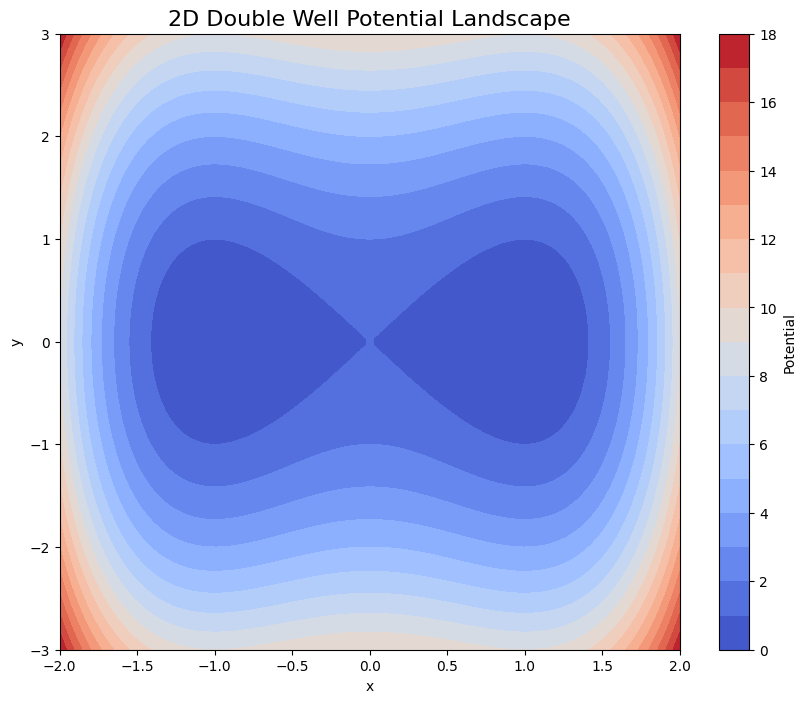

In [17]:
from double_well_potential_2d import potential, simulate_trajectory

"""
Main script for plotting and trajectory generation.
Imports potential and simulate_trajectory from double_well.py.
"""

# Plot the potential landscape
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-3, 3, 100)
XX, YY = np.meshgrid(x_plot, y_plot)
ZZ = potential(XX, YY)

plt.figure(figsize=(10, 8))
plt.contourf(XX, YY, ZZ, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
plt.title('2D Double Well Potential Landscape', fontsize= 16)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Generate a single SDE trajectory

def get_single_trajectory(x0, y0, T):
    """
    Produce SDE trajectory starting at (x0, y0) over T steps.
    This function delegates the simulation to double_well.simulate_trajectory.
    """
    return simulate_trajectory(x0, y0, T)

In [ ]:
# from duffing_system_2d import simulate_trajectory

# """
# Main script for Duffing oscillator system simulation
# """

# # Set parameters for the Duffing oscillator
# delta = 0.5
# alpha = -1
# beta = 1
# gamma = 0
# omega = 0

# # Create a grid of points for phase space visualization
# x_plot = np.linspace(-2, 2, 100)
# y_plot = np.linspace(-2, 2, 100)
# XX, YY = np.meshgrid(x_plot, y_plot)

# # Calculate vector field for phase space plot
# U = YY  # dx/dt = y
# V = -delta*YY - alpha*XX - beta*(XX**3) + gamma*np.cos(omega*0)  # dy/dt at t=0

# # Normalize the arrows
# magnitude = np.sqrt(U**2 + V**2)
# U_norm = U / magnitude
# V_norm = V / magnitude

# # Plot the phase space
# plt.figure(figsize=(6, 4))
# plt.streamplot(XX, YY, U, V, density=1.5, color='darkblue', linewidth=0.7)
# plt.quiver(XX[::10, ::10], YY[::10, ::10], U_norm[::10, ::10], V_norm[::10, ::10], 
#            color='red', scale=25)
# plt.title('Duffing Oscillator Phase Space')
# plt.xlabel('x (position)')
# plt.ylabel('y (velocity)')
# plt.grid(alpha=0.3)
# plt.show()

# def get_single_trajectory(x0, y0, T):
#     """
#     Produce SDE trajectory starting at (x0, y0) over T steps.
#     This function delegates the simulation to duffing_system_2d.simulate_trajectory.
    
#     Args:
#         x0: Initial x-coordinate (position)
#         y0: Initial y-coordinate (velocity)
#         T: Total simulation time steps
        
#     Returns:
#         Tuple of (data_matrix_single, lag_time)
#     """
#     return simulate_trajectory(x0, y0, T, delta=delta, alpha=alpha, beta=beta, gamma=gamma, omega=omega)

In [ ]:
## Choose a system (this is just for name)
# system = 'duffing' 
system = 'double_well'

In [ ]:
# Bandit parameters
k_arm= 32

# Total time
ttime= 12000 # 12000

In [ ]:
## The following part is for generating the data

def koopman_reward_func (action, k_grid= 4):
    action_x= action//k_grid
    action_y= action%k_grid
    x_borders= linspace (x_min,x_max, k_grid+1)
    y_borders= linspace (y_min,y_max, k_grid+1)
    x_lo= x_borders[action_x]
    x_hi= x_borders[action_x+1]
    y_lo= y_borders[action_y]
    y_hi= y_borders[action_y+1]
    x0_single= rrr.uniform (x_lo, x_hi)
    y0_single= rrr.uniform (y_lo, y_hi)
    
    T= 1000 # 1000
    
    data_matrix_single, lag_time= get_single_trajectory (x0_single, y0_single, T)
    # Extract data_X and data_Y from the data matrix
    data_X = data_matrix_single[:, :-1, :]
    data_Y = data_matrix_single[:, 1:, :]
    print(f"Shape of data_X: {data_X.shape}")
    print(f"Shape of data_Y: {data_Y.shape}")
    
    # Reshape data_X and data_Y into a single column
    X = data_X.reshape(-1, data_X.shape[2])  # 2D features
    Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
    # print(f"Shape of X: {X.shape}")
    # print(f"Shape of Y: {Y.shape}")
    
    # Separate data into two parts: train and validation
    len_all = X.shape[0]
    data_x_train = X[:int(0.7*len_all)]
    data_x_valid = X[int(0.7*len_all)+1:]
    
    data_y_train = Y[:int(0.7*len_all)]
    data_y_valid = Y[int(0.7*len_all)+1:]
    
    data_train = [data_x_train, data_y_train]
    data_valid = [data_x_valid, data_y_valid]
    
    #print(data_x_train.shape)
    
    checkpoint_file= f'example_{system}_bandit_ckpt.torch'
    basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=10).to(device)  # basis number would be 20
    
    
    solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                           target_dim=np.shape(data_x_train)[-1],
                                                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= f'example_{system}_fnn_bandit.torch', 
                                a_b_file= f'sde_coefficients_example_{system}_bandit.jbl', 
                            generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)
    solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=4,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )
    consistency= 0
    for ii in arange (len (solver.eigenvalues)):
        phi_x= solver.eigenfunctions (X)[ii]
        phi_y=  solver.eigenfunctions (Y)[ii]
        lmbd=  solver.eigenvalues[ii]
        consistency= consistency + la.norm (phi_y- lmbd*phi_x)**2
    print (consistency)
    
    return 16-consistency

In [ ]:
eps= 0.35
q_optimistic= 10
koopman_bandit= KoopmanBandit(k_arm= k_arm, epsilon=eps, initial= q_optimistic , sample_averages=True, reward_func= koopman_reward_func) 

In [ ]:
#main loop
#run ttime RL/Bandit steps
runs= 1
# ttime= 12000 # 12000
t0= time ()
rewards = np.zeros( (runs, ttime))
actions_taken   = []
best_action_list= []
for r in tqdm(range(runs)):
    koopman_bandit.reset()
    for t in range(ttime):
        action = koopman_bandit.act()
        reward = koopman_bandit.step(action)
        rewards[ r, t] = reward
        actions_taken.append (action)
        with open('bandit_state.txt', 'w') as f:
            f.write(f"current RL step: {int(t)}/{int(ttime)}\n")
        best_action= argmax (koopman_bandit.q_estimation)
        best_action_list.append (best_action)
    print ('run finished:', r)
t1= time ()

In [ ]:
#np.savetxt ('bandit_state.txt', [int(ttime)])

In [ ]:
# joblib.dump ((best_action_list,koopman_bandit.q_estimation ), 'bandit_history32x32_12000steps_example.jbl')
filename = f'bandit_history{k_arm}x{k_arm}_{ttime}steps_example_{system}.jbl'
joblib.dump(
    (best_action_list, koopman_bandit.q_estimation),
    filename
)

print ('bandit algoritm took: ', t1-t0)

In [ ]:
## The following part is for plotting
#  Plot the eigenfunctions

def get_initial_point (action, k_grid= 4):
    action_x= action//k_grid
    action_y= action%k_grid
    x_borders= linspace (x_min,x_max, k_grid+1)
    y_borders= linspace (y_min,y_max, k_grid+1)
    x_lo= x_borders[action_x]
    x_hi= x_borders[action_x+1]
    y_lo= y_borders[action_y]
    y_hi= y_borders[action_y+1]
    x0_single= rrr.uniform (x_lo, x_hi)
    y0_single= rrr.uniform (y_lo, y_hi)
    return x0_single,y0_single

file_name = f'bandit_history{k_arm}x{k_arm}_{ttime}steps_example_{system}.jbl'
best_action_list, q_estimation = joblib.load(file_name)
os.makedirs('figures_bandit', exist_ok=True)

# Prepare a list to accumulate all state‑space samples
X_list = []

for step_view in [25, 100, 500, 1000, 2000, 4000]:
    # 1. Select Bandit action → initial state
    best_action = best_action_list[step_view]
    x0_best, y0_best = get_initial_point(best_action, k_grid=k_arm)

    # 2. Simulate one trajectory of length T1
    T1 = 2 * step_view + 500
    data_matrix_single, lag_time = get_single_trajectory(x0_best, y0_best, T1)

    # 3. Build X (current) and Y (next) arrays
    data_X = data_matrix_single[:, :-1, :]
    data_Y = data_matrix_single[:,  1:, :]
    X = data_X.reshape(-1, data_X.shape[2])
    Y = data_Y.reshape(-1, data_Y.shape[2])

    # 4. Split into 70% train / 30% valid
    len_all = X.shape[0]
    idx_split = int(0.7 * len_all)
    data_train = [X[:idx_split], Y[:idx_split]]
    data_valid = [X[idx_split + 1:], Y[idx_split + 1:]]

    # 5. Define NN dictionary & Koopman solver (unchanged)
    basis_function = KoopmanNNTorch(input_size=2, layer_sizes=[10], n_psi_train=10).to(device)
    solver = KoopmanSolverTorch(
        dic=basis_function,
        target_dim=X.shape[-1],
        reg=0.1,
        checkpoint_file=f'example_bandit_ckpt_{system}.torch',
        fnn_checkpoint_file=f'example_fnn_bandit_{system}.torch',
        a_b_file=f'sde_coefficients_example_bandit_{system}.jbl',
        generator_batch_size=2,
        fnn_batch_size=32,
        delta_t=lag_time
    )

    # 6. Train the model
    solver.build_with_generator(
        data_train=data_train,
        data_valid=data_valid,
        epochs=6,
        batch_size=256,
        lr=1e-5,
        log_interval=10,
        lr_decay_factor=0.8
    )

    # 7. Extract eigenvalues (for plotting on unit circle)
    evalues = solver.eigenvalues.T
    
    # 8. Accumulate this iteration’s X samples
    X_list.append(X)

    # 9. Stack all past samples
    X_all = np.vstack(X_list)

    # 10. Re‑evaluate current model’s eigenfunctions on EVERY point
    #     This guarantees the color at each point reflects the same (current) solver
    efuns_all = solver.eigenfunctions(X_all)

    # # 11. Plot eigenvalues on unit circle (Without saving to a txt file)
    # print("First 10 eigenvalues: ", evalues[:10])
    # plt.figure(figsize=(6, 4))
    # plt.scatter(evalues.real, evalues.imag, label='Eigenvalues')
    # theta = np.linspace(0, 2*np.pi, 100)
    # plt.plot(np.cos(theta), np.sin(theta), '--', label='Unit Circle')
    # plt.title(f'Eigenvalues (step_view = {step_view})')
    # plt.xlabel('Real Part')
    # plt.ylabel('Imaginary Part')
    # plt.axis('equal')
    # plt.grid(True, linestyle='--', linewidth=0.5)
    # plt.legend()
    # plt.show()

    # 11. Plot eigenvalues on unit circle and save to a txt file
    print("First 10 eigenvalues: ", evalues[:10])
    
    # Create figure for plotting eigenvalues
    plt.figure(figsize=(6, 4))
    plt.scatter(evalues.real, evalues.imag, label='Eigenvalues')
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), '--', label='Unit Circle')
    plt.title(f'Eigenvalues at step = {step_view}')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.axis('equal')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    
    # Save the figure to the specified path
    plt.savefig(f'figures_bandit/eigenvalue_{system}_bandit_step_{step_view}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save the first 10 eigenvalues to a text file
    with open(f'figures_bandit/eigenvalues_{system}_bandit_step_{step_view}.txt', 'w') as f:
        f.write(f"First 10 eigenvalues (step_view = {step_view}):\n")
        for i, evalue in enumerate(evalues[:10]):
            f.write(f"λ{i+1} = {evalue.real:.6f} + {evalue.imag:.6f}j\n")
    
    # 12. Plot ACCUMULATED eigenfunctions (first two modes) on all points
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # ## First eigenfunction
    # sc1 = axs[0].scatter(
    #     X_all[:, 0], X_all[:, 1],
    #     c=np.real(efuns_all)[:, 0],
    #     cmap='coolwarm',
    #     alpha=0.6,
    #     label=f'At step {step_view}'
    # )
    # axs[0].set_title(f'1st Eigenfunction at step = {step_view}', fontsize=18)
    # axs[0].set_xlim(-2, 2)
    # axs[0].set_ylim(-1, 2)
    # fig.colorbar(sc1, ax=axs[0], shrink=0.7, aspect=20)

    ## First eigenfunction - with consistent coloring for values within 0.1 difference
    ## Normalize the eigenfunctions
    # Get the real part of the first eigenfunction
    efun_values = np.real(efuns_all)[:, 0]
    
    ## First eigenfunction - with consistent coloring for values within 0.1 difference
    # Get the real part of the first eigenfunction
    efun_values = np.real(efuns_all)[:, 0]
    
    # Round values to nearest 0.1 to create discrete color bands
    efun_discretized = np.round(efun_values * 10) / 10
    
    sc1 = axs[0].scatter(
        X_all[:, 0], X_all[:, 1],
        c=efun_discretized,  # Use discretized values for coloring
        cmap='coolwarm',
        alpha=0.6,
        label=f'At step {step_view}'
    )
    axs[0].set_title(f'1st Eigenfunction at step = {step_view}', fontsize=20)
    axs[0].set_xlim(-2, 2)
    axs[0].set_ylim(-1, 2)
    
    # Create colorbar with single decimal precision
    cbar1 = fig.colorbar(sc1, ax=axs[0], shrink=0.7, aspect=20, format='%.1f')

    # Second eigenfunction
    sc2 = axs[1].scatter(
        X_all[:, 0], X_all[:, 1],
        c=np.real(efuns_all)[:, 1],
        cmap='coolwarm',
        alpha=0.6,
        label=f'At step {step_view}'
    )
    axs[1].set_title(f'2nd Eigenfunction at step = {step_view}', fontsize=20)
    axs[1].set_xlim(-2, 2)
    axs[1].set_ylim(-1, 2)
    fig.colorbar(sc2, ax=axs[1])

    # fig.suptitle(f'2D Double Well Potential System', fontsize=20)
    plt.tight_layout()
    plt.show()

    # 13. Save the combined figure
    fig.savefig(f'figures_bandit/eigenfunction_{system}_bandit_step_{step_view}.png')


In [ ]:
## Plot the reward map with Double Well potential system

q_reshaped = q_estimation.reshape ((k_arm,k_arm))
q_reshaped[q_reshaped<0]=6

k_grid= k_arm
x_borders= linspace(x_min,x_max, k_grid+1)
y_borders= linspace(y_min,y_max, k_grid+1)

x_plot = np.linspace(x_min, x_max, 100)
y_plot = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(x_plot, y_plot)
XX2, YY2= meshgrid( x_borders[1:]-diff(x_borders)[0]/2, y_borders[1:]-diff(y_borders)[0]/2)

deltaq=-0.1*XX2**2+ 0.2*YY2**2
q_new= q_reshaped-deltaq
# Calculate the potential at each point
ZZ = potential(XX, YY)


fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

pc= ax2.pcolor (x_borders[1:]-diff(x_borders)[0]/2, y_borders[1:]-diff(y_borders)[0]/2, q_new, alpha= 0.5, cmap= 'jet')
ax2.contourf(XX, YY, ZZ, levels=120, cmap='coolwarm', alpha = 0.3)
cbar4 = fig2.colorbar(pc, ax=ax2)
plt.title('Reward Map', fontsize= 22)
plt.xlabel('x', fontsize= 20)
plt.ylabel('y', fontsize=20)
plt.savefig ('figures_bandit/bandit_reward_map.png')
plt.show()

In [ ]:
# ## Plot the reward map with Duffing oscillator system

# # Set parameters for the Duffing oscillator
# delta = 0.5
# alpha = -1
# beta = 1
# gamma = 0
# omega = 0

# # Reshape Q-values into a grid
# q_reshaped = q_estimation.reshape((k_arm, k_arm))
# q_reshaped[q_reshaped < 0] = 6

# # Create the grid
# k_grid = k_arm
# x_borders = np.linspace(x_min, x_max, k_grid+1)
# y_borders = np.linspace(y_min, y_max, k_grid+1)

# # Create finer grid for visualization
# x_plot = np.linspace(x_min, x_max, 100)
# y_plot = np.linspace(y_min, y_max, 100)
# XX, YY = np.meshgrid(x_plot, y_plot)

# # Create grid points for q-values
# XX2, YY2 = np.meshgrid(x_borders[1:]-np.diff(x_borders)[0]/2, 
#                         y_borders[1:]-np.diff(y_borders)[0]/2)

# # Apply transformation to q-values (keeping your original transformation)
# deltaq = -0.1 * XX2**2 + 0.2 * YY2**2
# q_new = q_reshaped - deltaq

# # Calculate the vector field for the Duffing system
# U = YY  # dx/dt = y
# V = -delta*YY - alpha*XX - beta*(XX**3) + gamma*np.cos(omega*0)  # dy/dt at t=0

# # Calculate vector magnitude for coloring the streamplot
# magnitude = np.sqrt(U**2 + V**2)

# # Create the plot
# fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

# # Plot the Q-value heatmap
# pc = ax2.pcolor(x_borders[1:]-np.diff(x_borders)[0]/2, 
#                 y_borders[1:]-np.diff(y_borders)[0]/2, 
#                 q_new, alpha=0.5, cmap='jet')

# # Plot the Duffing phase space using streamplot
# # Note: streamplot returns a StreamplotSet object
# streamplot = ax2.streamplot(XX, YY, U, V, density=1.5, 
#                            color='darkblue', linewidth=0.7)

# # Set the alpha of the streamplot lines
# # The lines are stored as a LineCollection object
# streamplot.lines.set_alpha(0.3)

# # Add a colorbar for the Q-values
# cbar4 = fig2.colorbar(pc, ax=ax2)

# # Add title and labels
# plt.title('Reward Map with Duffing Oscillator Phase Space', fontsize=22)
# plt.xlabel('x (position)', fontsize=20)
# plt.ylabel('y (velocity)', fontsize=20)

# # Save and display the figure
# plt.savefig('figures_bandit/bandit_reward_map_duffing.png')
# plt.show()